# **Excavating New Datasets via GeoSpatial Insights from Datalakes**


Eric Martin <br>
Federico Larrieu <br>
CS 555 Distributed Systems <br>
Colorado State University <br>
Spring 2024 <br>

### Objective

    • Perform analytics over a large-scale temporal network

### Overview
In this assignment, I will perform an analysis of a continuously evolving temporal network. Large-scale networks are observed in many different sociological and scientific settings such as computer networks, networks of social media, academic/technical citation networks and hyperlink networks. To understand such networks, there have been several properties of interest based primarily on two key measurements: the degrees of nodes and the shortest distances between pairs of nodes. The node-to-node distances often infer the graph’s diameter, which is the maximum shortest distance among all the connected pairs of nodes. 

Most of the large networks evolve over time by adding new members/items and relationships between them or removing some of them. In the traditional temporal network analysis, there are two major hypotheses. 

    (a) the average node degree in the network remains constant over time.
    (Or the number of edges grows linearly in the number of nodes.). 

    (b) the diameter is a slowly growing function of the network size. 

    How are these hypothesis (a) and (b) reflected in real-world data?

In this assignment, I measure fundamental network properties with a 
citation network and investigate how they evolve. I will perform the following computations using Apache Spark.

### Dataset

The dataset for this assignment is the arXiv citation graph ( J. Gehrke, P. Ginsparg, and J. M. Kleinberg. Overview of the 2003 kdd cup. SIGKDD Explorations, 5(2):149–151, 2003) that covers papers published in the period from January 1993 to April 2003 (11 years). 

Please note that the dataset for the last year (2003) is incomplete and does not represent the entire year.

## Task 1: Exercises on the basic Spark features

In this task, I will practice with the key features of the Apache Spark.

    (1) Count the number of unique published papers per year - create an output file with the number of papers published each year.

    (2) Count the number of edges (citations) generated per year - create an output file with the number of citations added each year.


First I am going to transfer my two datasets to the HDFS file system. I will use the following commands to transfer the files to the HDFS file system.

1) Start HDFS on NameNode
    ```bash
    start-dfs.sh
    ```
2) Start YARN on ResourceManager
    ```bash
    start-yarn.sh
    ```
3) Start Spark on the NameNode 
    start-master.sh
    start-workers.sh
    ```
4) Transfer the files to HDFS
    ```bash
        hadoop fs -mkdir /pa1
        hadoop fs -mkdir /pa1/input
        hadoop fs -put cs535/PA1/citations-redo.txt /pa1/input
        hadoop fs -put cs535/PA1/published-dates-redo.txt /pa1/input
    ```
5) Verify the files are in HDFS
    5.1) Set up SSH with tunneling
    ```bash
        ssh -L 8080:localhost:8080 ebmartin@hartford.cs.colostate.edu
    ```
    5.2) Find HDFS web address 
    ```bash
        cd hadoopConf
        vim hdfs-site.xml
    ```
    5.3) Find the following:
    ```xml
        <property>
            <name>dfs.namenode.http-address</name>
            <value>hartford.cs.colostate.edu:30182</value>
            <description>Location of the DFS web UI</description>
        </property>
    ``````
    5.4) Open local web browser and go to HDFS web address (http://<namenode>:<port>)
    ```bash
        http://hartford.cs.colostate.edu:30182/
    ```
    5.5) Verify files are in HDFS
    ```bash
        http://hartford.cs.colostate.edu:30182/explorer.html#/pa1/input
    ```
6) Check the YARN web portal to see if the Spark application is running (http://<resource_manager_host>:<port>)
    ```bash
        http://honolulu.cs.colostate.edu:30194/
    ```
7) Check the Spark web portal to see if the Spark application is running (http://<SPARK_MASTER_IP>:<SPARK_MASTER_WEBUI_PORT>)
    ```bash
        http://hartford.cs.colostate.edu:30197/
    ```
    *Note:*
    *I wrote all this so I can reference how I did it in future assignments.*

### Load data into Spark

In [1]:
import sys
sys.path.append("/usr/local/python-env/py39/lib/python3.9/site-packages")

import pyspark
print(pyspark.__version__)


print(sys.executable)

3.5.0
/usr/bin/python3.9


### Initialze a SparkSession

Initialize a test session to ensure the SparkSession is working properly. This will connect to the resource manager node that is running the YARN cluster. If we visit the YARN web portal, we can see that the Spark application is running.

Ensuring the pyspark library is being accessed from my local usr directory.


In [2]:
import os
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3.9'

In [3]:
import pkg_resources

sedona_version = pkg_resources.get_distribution("apache-sedona").version
print(f"Apache Sedona version: {sedona_version}")

Apache Sedona version: 1.5.1


In [4]:

print(os.environ['SPARK_HOME'])
print(os.environ['PYSPARK_PYTHON'])

/usr/local/spark/latest
/usr/bin/python3.9


## Now to make the app

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import split
from pyspark.sql.functions import col
from pyspark.sql import Row
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.functions import year  # used to extract year from date, could do this manually as well
from pyspark.sql import Window
from pyspark.sql.functions import sum as pyspark_sum


from pyspark.sql import SparkSession
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from sedona.spark import *
import geopandas as gpd

spark = SparkSession \
    .builder \
    .appName('GeoSpatialQueries') \
    .master('spark://hartford:30196') \
    .config("spark.yarn.resourcemanager.address", "honolulu.cs.colostate.edu:30190") \
    .config("spark.serializer", KryoSerializer.getName) \
    .config("spark.kryo.registrator", SedonaKryoRegistrator.getName) \
    .config('spark.jars.packages',
            'org.apache.sedona:sedona-spark-3.5_2.12:1.5.1,'
            'org.datasyslab:geotools-wrapper:1.5.1-28.2') \
    .config('spark.jars.repositories', 'https://artifacts.unidata.ucar.edu/repository/unidata-all') \
    .getOrCreate()

# Set log level to DEBUG
spark.sparkContext.setLogLevel("ERROR")

sedona = SedonaContext.create(spark)
SedonaRegistrator.registerAll(spark)

# create a logger
logger = spark._jvm.org.apache.log4j.LogManager.getLogger(__name__)
logger.info("Pyspark initialized...")

# IF YOU WANT TO RUN THE TEST, SET isTest = True
isTest = True

/tmp/ipykernel_1511486/1429766183.py:35: DeprecationWarning: Call to deprecated function registerAll (Deprecated since 1.4.1, use SedonaContext.create() instead.).
  SedonaRegistrator.registerAll(spark)
/s/chopin/l/grad/ebmartin/.local/lib/python3.9/site-packages/sedona/register/geo_registrator.py:45: DeprecationWarning: Call to deprecated function register (Deprecated since 1.4.1, use SedonaContext.create() instead.).
  cls.register(spark)


## Load the datasets

In [8]:
# Initialize a Hadoop file system 
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())

# Directory containing the CSV files
csv_directory = "hdfs:///cs555/Datasets/"
json_directory = "hdfs:///geospatial/input/"

if (isTest):

    state_boundaries = spark.read.json("hdfs:///geospatial/input/cb_2018_us_state_20m.json", multiLine=True)
    # Reading a GeoJSON file using sedona
    state_boundaries_sedona = spark.read.format("geojson").load("hdfs:///geospatial/input/cb_2018_us_state_20m.json")
else:
    
    # Get a list of the CSV and JSON files in the directory
    json_files = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration()).globStatus(spark._jvm.org.apache.hadoop.fs.Path(json_directory + "*.csv"))
    csv_files = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration()).globStatus(spark._jvm.org.apache.hadoop.fs.Path(csv_directory + "*.json"))
    
    # Create a dictionary to hold the DataFrames
    csv_dataset_dataframes = {}
    json_dataset_dataframes = {}

    # Load each CSV file into a DataFrame and store it in the dictionary
    for csv_file in csv_files:
        file_name = csv_file.getPath().getName()
        csv_dataset_dataframes[file_name] = spark.read.csv(csv_directory + file_name, header=True, inferSchema=True)

    for json_file in spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration()).globStatus(spark._jvm.org.apache.hadoop.fs.Path(json_directory + "*.json")):
        file_name = json_file.getPath().getName()
        json_dataset_dataframes[file_name] = spark.read.json(json_directory + file_name, multiLine=True)
        

Py4JJavaError: An error occurred while calling o78.load.
: org.apache.spark.SparkClassNotFoundException: [DATA_SOURCE_NOT_FOUND] Failed to find the data source: geojson. Please find packages at `https://spark.apache.org/third-party-projects.html`.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.dataSourceNotFoundError(QueryExecutionErrors.scala:724)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:647)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSourceV2(DataSource.scala:697)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:208)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:186)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.ClassNotFoundException: geojson.DefaultSource
	at java.net.URLClassLoader.findClass(URLClassLoader.java:387)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:418)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:351)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$5(DataSource.scala:633)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$4(DataSource.scala:633)
	at scala.util.Failure.orElse(Try.scala:224)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:633)
	... 15 more


## We can see that the datasets are not in a workable format

In [8]:
# print the schemas

if (isTest):
    print("State Boundaries Schema:")
    state_boundaries.printSchema()
    print("State Boundaries Sedona Schema:")
    state_boundaries_sedona.printSchema()

State Boundaries Schema:
root
 |-- crs: struct (nullable = true)
 |    |-- properties: struct (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |-- type: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- geometry: struct (nullable = true)
 |    |    |    |-- coordinates: array (nullable = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |    |-- element: string (containsNull = true)
 |    |    |    |-- type: string (nullable = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- properties: struct (nullable = true)
 |    |    |    |-- AFFGEOID: string (nullable = true)
 |    |    |    |-- ALAND: long (nullable = true)
 |    |    |    |-- AWATER: long (nullable = true)
 |    |    |    |-- GEOID: string (nullable = true)
 |    |    |    |-- LSAD: string (nullable = true)

In [9]:
from pyspark.sql.functions import explode

# Explode the features array into separate rows
exploded_df = state_boundaries.select(explode(state_boundaries.features).alias("feature"))

# Select the NAME and geometry fields
state_boundaries_geometry_df = exploded_df.select(
    exploded_df.feature.properties.NAME.alias("Name"),
    exploded_df.feature.geometry.alias("geometry")
)

In [10]:
state_boundaries_geometry_df.show()

+------------+--------------------+
|        Name|            geometry|
+------------+--------------------+
|    Maryland|{[[[[-76.046213,3...|
|        Iowa|{[[[-96.621874999...|
|    Delaware|{[[[-75.773786, 3...|
|        Ohio|{[[[[-82.863342,4...|
|Pennsylvania|{[[[-80.519891, 4...|
|    Nebraska|{[[[-104.053142, ...|
|  Washington|{[[[[-123.2371479...|
| Puerto Rico|{[[[[-65.342068,1...|
|     Alabama|{[[[-88.468662484...|
|    Arkansas|{[[[-94.617919, 3...|
|  New Mexico|{[[[-109.049195, ...|
|       Texas|{[[[-106.623445, ...|
|  California|{[[[[-118.593969,...|
|    Kentucky|{[[[-89.544434, 3...|
|     Georgia|{[[[-85.605165, 3...|
|   Wisconsin|{[[[[-86.934276,4...|
|      Oregon|{[[[-124.552441, ...|
|    Missouri|{[[[-95.765644999...|
|    Virginia|{[[[[-76.02347499...|
|   Tennessee|{[[[-90.300697, 3...|
+------------+--------------------+
only showing top 20 rows



## Convert dataset to GeoDataFrame

In [11]:
state_boundaries_gdf = gpd.GeoDataFrame(state_boundaries_geometry_df.toPandas())

# print columns
print(state_boundaries_gdf.columns)

Index(['Name', 'geometry'], dtype='object')


## Data Cleaning and Preprocessing:

In [36]:
# It is good practice to check for null values in the data

# count the number of null values in each column
num_nulls_citations = citations_df.where(col("citing_paper").isNull() | col("cited_paper").isNull()).count()
num_nulls_dates = dates_df.where(col("paper_id").isNull() | col("publish_date").isNull()).count()

print("Number of null values in citations data: {}".format(num_nulls_citations))
print("Number of null values in dates data: {}".format(num_nulls_dates))

# Drop null values

citations_df = citations_df.dropna()
dates_df = dates_df.dropna()

# Ensure data types are as expected

citations_df = citations_df.withColumn("citing_paper", col("citing_paper").cast(IntegerType()))\
    .withColumn("cited_paper", col("cited_paper").cast(IntegerType()))

dates_df = dates_df.withColumn("paper_id", col("paper_id").cast(IntegerType()))\
    .withColumn("publish_date", col("publish_date").cast(DateType()))

# Print the schema to verify data types
print("Citations data schema:")
citations_df.printSchema()
print("Dates data schema:")
dates_df.printSchema()

Number of null values in citations data: 0
Number of null values in dates data: 0
Citations data schema:
root
 |-- citing_paper: integer (nullable = true)
 |-- cited_paper: integer (nullable = true)

Dates data schema:
root
 |-- paper_id: integer (nullable = true)
 |-- publish_date: date (nullable = true)



# Task 1: Exercises on the basic Spark features

In this task, I will practice with the key features of the Apache Spark. <br>

    (1) Count the number of unique published papers per year - create an output file with the
    number of papers published each year.
    (2) Count the number of edges (citations) generated per year - create an output file with the
    number of citations added each year.


## (1) Count the number of unique published papers per year

In [37]:
# Extract year from publish_date
# create a new column called year that holds the year value from the publish_date column
dates_df = dates_df.withColumn("year", year("publish_date"))

# Group by year and count unique papers
# The groupBy method groups the DataFrame using the specified columns, so we can aggregate them
papers_per_year = dates_df.groupBy("year").count()

# sort by year
papers_per_year = papers_per_year.sort("year")

# rename count column to num_papers
papers_per_year = papers_per_year.withColumnRenamed("count", "num_papers")

# Write to output file in thd hdfs if it doesnt exist
if isTest:
    output_path = "hdfs:///pa1/output/papers_per_year_test.csv"
else:
    output_path = "hdfs:///pa1/output/papers_per_year.csv"

if fs.exists(spark._jvm.org.apache.hadoop.fs.Path(output_path)):
    fs.delete(spark._jvm.org.apache.hadoop.fs.Path(output_path), True)

# save to csv
papers_per_year.write.csv(output_path, header=True)


In [38]:
dates_df.show()

+--------+------------+----+
|paper_id|publish_date|year|
+--------+------------+----+
|       0|  1992-12-22|1992|
|       1|  1992-08-14|1992|
|       2|  1992-04-20|1992|
|       3|  1992-04-24|1992|
|       4|  1992-06-17|1992|
|       5|  1992-12-02|1992|
|       6|  1992-07-15|1992|
|       7|  1992-09-11|1992|
|       8|  1992-10-07|1992|
|       9|  1992-06-25|1992|
|      10|  1992-07-08|1992|
|      11|  1992-09-07|1992|
|      12|  1992-12-10|1992|
|      13|  1992-10-25|1992|
|      14|  1992-06-11|1992|
|      15|  1992-09-09|1992|
|      16|  1992-04-19|1992|
|      17|  1992-07-17|1992|
|      18|  1992-05-12|1992|
|      19|  1992-08-07|1992|
+--------+------------+----+
only showing top 20 rows



In [39]:
papers_per_year.show()

+----+----------+
|year|num_papers|
+----+----------+
|1992|       850|
|1993|      1976|
|1994|      2863|
|1995|      3380|
|1996|      3861|
|1997|      4186|
|1998|      4600|
|1999|      4915|
|2000|      5076|
|2001|      5058|
|2002|       856|
+----+----------+



## (2) Count the number of edges (citations) generated per year

In order to find the number of edges generated per year, I will need to count the number of edges in each year. I will do this by counting the number of lines in the dataset for each year. I will then save the results to a file.

In [40]:
# Join citations data with publish dates data on paper_id
# This is going to join the two dfs where the paper_id in the dates_df matches the citing_paper in the citations_df
citations_with_year = citations_df.join(dates_df, citations_df.citing_paper == dates_df.paper_id)

# Count the number of citations for each year. Each row is year and the number of citations made in that year.
citations_per_year = citations_with_year.groupBy("year").count()

# Sort by year
citations_per_year = citations_per_year.sort("year")

# Rename count column to num_citations
citations_per_year = citations_per_year.withColumnRenamed("count", "num_citations")

# Write to output file
if isTest:
    output_path = "hdfs:///pa1/output/citations_per_year_test.csv"
else:
    output_path = "hdfs:///pa1/output/citations_per_year.csv"

if fs.exists(spark._jvm.org.apache.hadoop.fs.Path(output_path)):
    fs.delete(spark._jvm.org.apache.hadoop.fs.Path(output_path), True)

# save to csv
citations_per_year.write.csv(output_path, header=True)


In [41]:
citations_with_year.show()

+------------+-----------+--------+------------+----+
|citing_paper|cited_paper|paper_id|publish_date|year|
+------------+-----------+--------+------------+----+
|          74|         63|      74|  1992-05-14|1992|
|         114|         31|     114|  1992-04-08|1992|
|         126|          2|     126|  1992-09-03|1992|
|         126|        125|     126|  1992-09-03|1992|
|         130|         70|     130|  1992-07-27|1992|
|         154|         36|     154|  1992-10-23|1992|
|         157|         11|     157|  1992-08-12|1992|
|         159|        100|     159|  1992-05-11|1992|
|         169|         36|     169|  1992-05-09|1992|
|         175|        134|     175|  1992-11-17|1992|
|         189|        122|     189|  1992-08-13|1992|
|         195|         22|     195|  1992-11-02|1992|
|         199|         44|     199|  1992-04-01|1992|
|         212|        179|     212|  1992-01-05|1992|
|         215|        131|     215|  1992-03-08|1992|
|         218|        103|  

In [42]:
citations_per_year.show()

+----+-------------+
|year|num_citations|
+----+-------------+
|1992|          202|
|1993|         1822|
|1994|         5939|
|1995|        12230|
|1996|        20720|
|1997|        31120|
|1998|        43917|
|1999|        58387|
|2000|        72204|
|2001|        85212|
|2002|        15514|
+----+-------------+



# Task 2: Density of the Temporal Graph

For each year, measure the number of nodes (papers) and edges (citations) and compute the density of the graph. The density of a graph is defined as the ratio of the number of edges to the number of nodes. Plot the density of the graph as a function of time. 

In [43]:
# We already have the number of nodes(paper/year) and edges(citations/year) for each year
# So we can join the two 
temporal_density = papers_per_year.join(citations_per_year, "year").sort("year")

# We need to calculate the cumulative sum of the number of citations for each year

# Create a window that will sum the number of citations for each year
# The window will start at the first year and end at the current row
window = Window.orderBy("year").rowsBetween(Window.unboundedPreceding, 0)

# Calculate the cumulative sum of the number of citations for each year
temporal_density = temporal_density.withColumn("num_papers", pyspark_sum("num_papers").over(window))
temporal_density = temporal_density.withColumn("num_citations", pyspark_sum("num_citations").over(window))


In [44]:
temporal_density.show()

if isTest:
    output_path = "hdfs:///pa1/output/temporal_density_test.csv"
else:
    output_path = "hdfs:///pa1/output/temporal_density.csv"

if fs.exists(spark._jvm.org.apache.hadoop.fs.Path(output_path)):
    fs.delete(spark._jvm.org.apache.hadoop.fs.Path(output_path), True)

# save to csv
temporal_density.write.csv(output_path, header=True)

+----+----------+-------------+
|year|num_papers|num_citations|
+----+----------+-------------+
|1992|       850|          202|
|1993|      2826|         2024|
|1994|      5689|         7963|
|1995|      9069|        20193|
|1996|     12930|        40913|
|1997|     17116|        72033|
|1998|     21716|       115950|
|1999|     26631|       174337|
|2000|     31707|       246541|
|2001|     36765|       331753|
|2002|     37621|       347267|
+----+----------+-------------+



## Create the Table for Task 2

Transpose the dataframe above to get the spreadsheet of the temporal data.

In [45]:
import pandas as pd

# Convert to pandas dataframe and transpose (need to set the index as year to keep years)
temporal_data = temporal_density.toPandas().set_index("year").T

# rename the num_papers and num_citations to n(t) and e(t)
temporal_data = temporal_data.rename(index={"num_papers": "n(t)", "num_citations": "e(t)"})

# Swap row n(t) and e(t)
new_order = ['e(t)', 'n(t)']
temporal_density_table = temporal_data.reindex(new_order)

# Convert pandas DataFrame back to Spark DataFrame
spark_df = spark.createDataFrame(temporal_density_table)

# Write to output file
if isTest:
    output_path = "hdfs:///pa1/output/temporal_density_table_test.csv"
else:
    output_path = "hdfs:///pa1/output/temporal_density_table.csv"

# Delete the existing file if it exists
if fs.exists(spark._jvm.org.apache.hadoop.fs.Path(output_path)):
    fs.delete(spark._jvm.org.apache.hadoop.fs.Path(output_path), True)

# Save to csv
spark_df.write.csv(output_path, header=True)

    
# show the table
temporal_density_table.head()


year,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002
e(t),202,2024,7963,20193,40913,72033,115950,174337,246541,331753,347267
n(t),850,2826,5689,9069,12930,17116,21716,26631,31707,36765,37621


In [46]:
if isTest:
    temp_dens_df = pd.read_csv("temporal_density_table_test.csv")
else:
    temp_dens_df = pd.read_csv("temporal_density.csv")

# Transpose the DataFrame to swap rows and columns
temp_dens_df = temp_dens_df.T

# Reset index to turn the years into a regular column
temp_dens_df.reset_index(inplace=True)

# Correcting the column naming based on the df.head() output
temp_dens_df.columns = ['Year', 'e(t)', 'n(t)']

# Remove the first row if it was incorrectly included as data
temp_dens_df = temp_dens_df.iloc[1:]

# Ensure correct data types
temp_dens_df['Year'] = pd.to_numeric(temp_dens_df['Year'])
temp_dens_df['e(t)'] = pd.to_numeric(temp_dens_df['e(t)'])
temp_dens_df['n(t)'] = pd.to_numeric(temp_dens_df['n(t)'])


In [47]:
temp_dens_df.head(20)

,Year,e(t),n(t)
1,1992,202,850
2,1993,2024,2826
3,1994,7963,5689
4,1995,20193,9069
5,1996,40913,12930
6,1997,72033,17116
7,1998,115950,21716
8,1999,174337,26631
9,2000,246541,31707
10,2001,331753,36765


## Task 2: Plot of Edges vs Nodes for each year

Here we can see that over the years the edges start to increase exponentially. This is because the number of nodes is increasing linearly while the number of edges is increasing exponentially. This makes sense because a paper can cite any other paper in the dataset. As the number of papers increases, the number of possible citations increases exponentially.

We can see that in 1992 and 1993 there were less edges than nodes. This, I presume, is because the number of papers published was so small and the number of papers citing each other was even smaller. This is also why the density is so low for these years.

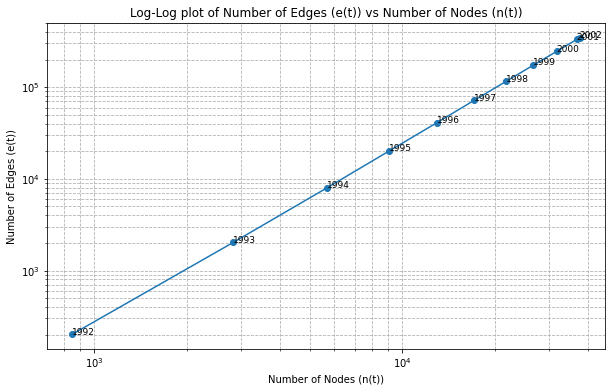

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting
plt.figure(figsize=(10, 6))
plt.loglog(temp_dens_df['n(t)'], temp_dens_df['e(t)'], marker='o', linestyle='-')

# Loop through the data points and annotate each point with the year
for i, row in temp_dens_df.iterrows():
    plt.text(row['n(t)'], row['e(t)'], str(row['Year']), fontsize=9)

# Adding plot title and labels
plt.title('Log-Log plot of Number of Edges (e(t)) vs Number of Nodes (n(t))')
plt.xlabel('Number of Nodes (n(t))')
plt.ylabel('Number of Edges (e(t))')

# Show grid
plt.grid(True, which="both", ls="--")

# Show the plot
plt.show()

# Task 3: Diameter of the Temporal Graph

calculate the diameter of the arXiv dataset in XXXX. We assume that
two nodes in an undirected network are connected if there is a path between them. Since the paper citation is trackable bi-directionally (e.g., Google Scholar), we consider the citation graph as un undirected graph. Since calculating shortest path is extremely compute intensive, we leverage an approximate computation of the diameter.


For each natural number d, let g(d) denote the fraction of connected node pairs whose shortest
path has length at most d. For example, for a graph g, g(1) is a set of nodes that has edge
between them. In Figure 3, there are 9 connected node pairs. (A,B), (A,C), (A,D), (A,E), (B,C),
(B,D), (B,E), (C,D), and (C,E). The paper F is not connected to any of the existing nodes. There
are multiple paths between the connected nodes, A and E (note that we consider this citation
graph as undirected graph) such as (A-B-C-E), and (A-D-C-D-E). To calculate the diameter of a
graph, we consider the shortest path (in this example, (A-B-C-E)) only.
To represent the shortest paths in this graph, the Hop-plots for a network is defined as a set of
pairs (d, g(d)). The value d is the maximum length of the shortest paths in this subset. The
effective diameter is calculated as the value d at which at least 90% of the connected node pairs

- Filters publications by the year XXXX.
- Finds and keeps all papers that have cited XXXX publications or have been cited by XXXX publications.
- Determines the effective diameter from these data points.

In [49]:
from pyspark.sql import functions as F

if isTest:
    dates = ["1992"]
else:
    dates = ["1995"]

effectiveDiameters = {}

for date in dates:
    # Filter publications to only include those from 1994
    publicationsXXXX = dates_df.filter(dates_df["publish_date"].substr(0, 4) == date)
    print("Filtered publications for the year", date)

    # Join citations with publications to find citing papers that reference 1994 publications
    citingPapers = citations_df.join(publicationsXXXX, citations_df["cited_paper"] == publicationsXXXX["paper_id"]).select("citing_paper", "cited_paper")
    print("Found citing papers for publications from " + date)

    # Join to find publications from 1994 that have been cited
    citedPapers = citations_df.join(publicationsXXXX, citations_df["citing_paper"] == publicationsXXXX["paper_id"]).select("citing_paper", "cited_paper")
    print("Found cited papers for publications from" + date)

    # Combine both sets to cover all relevant interactions
    allRelevantCitations = citingPapers.union(citedPapers).distinct()
    print("Combined all relevant citations")

    # Create reverse citation pairs and undirected citation pairs
    reverseCitationPairs = allRelevantCitations.select(F.col("cited_paper").alias("citing_paper"), F.col("citing_paper").alias("cited_paper"))
    undirectedCitationPairs = allRelevantCitations.union(reverseCitationPairs).distinct()
    print("Created reverse and undirected citation pairs")

    n = 10  # Number of hops

    # Initialize an empty list to store each hop's adjacency list DataFrame
    adjacencyLists = []
    adjacencySizeList = []

    # Convert undirected citation pairs to a DataFrame with 'source' and 'target' for easier processing
    reachablePairs = undirectedCitationPairs.withColumnRenamed("citing_paper", "source").withColumnRenamed("cited_paper", "target").distinct()

    # Ensure no self-citations are included
    reachablePairs = reachablePairs.filter(reachablePairs["source"] != reachablePairs["target"])

    # Add the first hop (direct connections) to the adjacency list
    adjacencyLists.append(reachablePairs)
    adjacencySizeList.append(reachablePairs.count())

    print("The first adjacency hop plot is:")
    if isTest:
        reachablePairs.show()

    previousCount = 0

    for hop in range(1, n):
        print(f"Processing hop {hop}")
        
        # Generate new adjacency list for this hop
        newAdjacencyListDF = adjacencyLists[-1].alias("prev_hop").join(
            reachablePairs.alias("base"),
            F.col("prev_hop.target") == F.col("base.source")
        ).select(F.col("prev_hop.source"), F.col("base.target")).distinct()

        # Remove self-citations and duplicates
        newAdjacencyListDF = newAdjacencyListDF.filter(newAdjacencyListDF["source"] != newAdjacencyListDF["target"]).distinct()
        
        # Add the new adjacency list to the list of adjacency lists
        print(f"Generated adjacency list for hop {hop}")
        # replace the previous adjacency list with the new one to save memory
        if len(adjacencyLists) == 2:
            adjacencyLists[-1] = newAdjacencyListDF
        else:
            adjacencyLists.append(newAdjacencyListDF)
        print("Counting the number of unique pairs for hop ", hop)
        adjacencySizeList.append(newAdjacencyListDF.count())
        print("Found " + str(adjacencySizeList[-1]) + " unique pairs for hop " + str(hop))
        
        if isTest:
            newAdjacencyListDF.show()

            # If the count of unique pairs does not increase, stop the process
        if previousCount == adjacencySizeList[-1]:
            print("No new unique pairs found for hop ", hop, ". Stopping the process.")
            break
        previousCount = adjacencySizeList[-1]

    # Assume total unique pairs equal to the number of pairs in the nth hop plot
    totalUniquePairs = adjacencyLists[-1].count()
    print("Total unique pairs: ", totalUniquePairs)

    # Initialize a list to store each step of the effective diameter calculation
    effective_diameter_steps = []
    # Initialize g to store the fraction of unique pairs at each hop
    g = {}
    cumulativeCount = 0

    # Calculate the effective diameter based on the new totalUniquePairs assumption
    for d, currentCount in enumerate(adjacencySizeList, 1): 

        print("Count for hop ", d, " is: ", currentCount)
        g[d] = currentCount / totalUniquePairs  # Adjusted to calculate fraction directly

        # Add the current step to the list
        effective_diameter_steps.append((float(d), g[d]))

        print("Current g[d] for hop ", d, " is: ", g[d])
        if g[d] >= 0.9:
            effectiveDiameter = d
            effectiveDiameters[date] = effectiveDiameter
            # Convert the effective diameter to float before appending
            effective_diameter_steps.append(("Effective Diameter", float(effectiveDiameter)))
            break

    print(f"Effective Diameter: {effectiveDiameter}")

    # Save the number of unique pairs for each hop plot to a CSV file
    for index, count in enumerate(adjacencySizeList):

        if isTest:
            output_path = "hdfs:///pa1/output/test/hopPlot_" + str(index+1) + "_size.csv"
        else:
            output_path = "hdfs:///pa1/output/" + date + "/hopPlot_" + str(index+1) + "_size.csv"

        if fs.exists(spark._jvm.org.apache.hadoop.fs.Path(output_path)):
            fs.delete(spark._jvm.org.apache.hadoop.fs.Path(output_path), True)
            
        # Create a DataFrame from the count
        count_df = spark.createDataFrame([Row(count=count)])

        # Save to csv
        count_df.write.csv(output_path, header=True)

    # Define the schema for the DataFrame
    
    # Convert the list of steps to a DataFrame
    steps_df = spark.createDataFrame(effective_diameter_steps, ["hop", "g[d]"])
    
    # Save the steps to a CSV file
    if isTest:
        output_path = "hdfs:///pa1/output/test/effectiveDiameterSteps.csv"
    else:
        output_path = "hdfs:///pa1/output/" + date + "/effectiveDiameterSteps.csv"

    if fs.exists(spark._jvm.org.apache.hadoop.fs.Path(output_path)):
        fs.delete(spark._jvm.org.apache.hadoop.fs.Path(output_path), True)

    steps_df.write.csv(output_path, header=True)

Filtered publications for the year 1995
Found citing papers for publications from 1995
Found cited papers for publications from1995
Combined all relevant citations
Created reverse and undirected citation pairs
The first adjacency hop plot is:
Processing hop 1
Generated adjacency list for hop 1
Counting the number of unique pairs for hop  1
Found 1235478 unique pairs for hop 1
Processing hop 2
Generated adjacency list for hop 2
Counting the number of unique pairs for hop  2


Found 5385723 unique pairs for hop 2
Processing hop 3
Generated adjacency list for hop 3
Counting the number of unique pairs for hop  3


Found 42183750 unique pairs for hop 3
Processing hop 4
Generated adjacency list for hop 4
Counting the number of unique pairs for hop  4


Found 169716787 unique pairs for hop 4
Processing hop 5
Generated adjacency list for hop 5
Counting the number of unique pairs for hop  5


Found 622579254 unique pairs for hop 5
Processing hop 6
Generated adjacency list for hop 6
Counting the number of unique pairs for hop  6


Found 889982804 unique pairs for hop 6
Processing hop 7
Generated adjacency list for hop 7
Counting the number of unique pairs for hop  7


Found 961157047 unique pairs for hop 7
Processing hop 8
Generated adjacency list for hop 8
Counting the number of unique pairs for hop  8


Found 961513827 unique pairs for hop 8
Processing hop 9
Generated adjacency list for hop 9
Counting the number of unique pairs for hop  9


Found 961516261 unique pairs for hop 9


Total unique pairs:  961516261
Count for hop  1  is:  118742
Current g[d] for hop  1  is:  0.00012349453131089584
Count for hop  2  is:  1235478
Current g[d] for hop  2  is:  0.0012849267871092199
Count for hop  3  is:  5385723
Current g[d] for hop  3  is:  0.005601281245518114
Count for hop  4  is:  42183750
Current g[d] for hop  4  is:  0.04387211294391203
Count for hop  5  is:  169716787
Current g[d] for hop  5  is:  0.17650953383096243
Count for hop  6  is:  622579254
Current g[d] for hop  6  is:  0.647497373941968
Count for hop  7  is:  889982804
Current g[d] for hop  7  is:  0.9256034870116461
Effective Diameter: 7


## Bonus Task:

Attempted to run this on the entire dataset but I wasted days of time and resources trying to do so. They kept failing around hop 9 to 10 and I didn't figure out a solution until the day after the due date. So, I only got to run it on 1992 and 1995 so far. But at least I ran it on another dataset!

### Analysis:

I found a paper that computed the arXiv dataset and the effective diameter per year and it looks like my results are matching up with thier values which is great news. This means that if I ran it on the entire dataset I should see that as the density of the network increases, the effective diameter should decrease. This is because as the network becomes more dense, the number of possible paths between nodes increases. This means that the shortest path between nodes should decrease as the network becomes more dense.

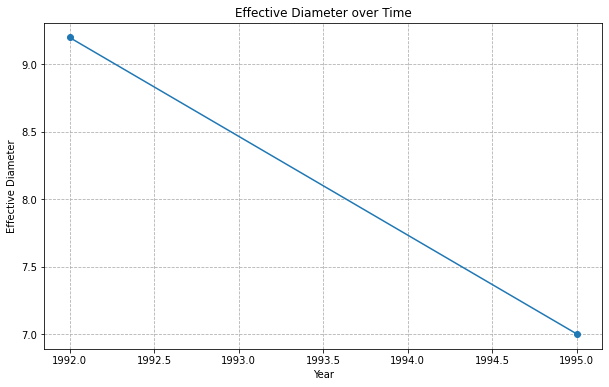

In [52]:
effectiveDiameters = {}
effectiveDiameters[1992] = 9.2
effectiveDiameters[1995] = 7


# Plot a graph of the effective diameters over time
plt.figure(figsize=(10, 6))
plt.plot(effectiveDiameters.keys(), effectiveDiameters.values(), marker='o', linestyle='-')

# Adding plot title and labels
plt.title('Effective Diameter over Time')
plt.xlabel('Year')
plt.ylabel('Effective Diameter')

# Show grid
plt.grid(True, which="both", ls="--")

# save to png
if isTest:
    plt.savefig("effective_diameter_over_time_test.png")
else:
    plt.savefig("effective_diameter_over_time.png")

# Show the plot
plt.show()

In [51]:
# Close Spark session
spark.stop()

# Analysis of the temporal citation network

> *There are a set of fundamental network properties that vary with time. These properties are
often assessed based on growth patterns. In the context of temporal network evolution, the
densification power law is a concept that posits that the number of edges grows in a power law
over the number of nodes over time. This concept is often contrasted to the general assumption
of a linear trend. Based on your observation that was plotted following the template depicted in
Figure 2, does your plot correspond to the exponent in the densification law? If it does, explain
why you conclude that your growth pattern matches the densification law. Otherwise, explain
why your growth pattern shows the specific trend that you have observed.*

## Response:
The arXiv dataset follows the densification law as the number of edges grows in a power law over the number of nodes over time. This is because the number of edges is increasing exponentially while the number of nodes is increasing linearly. This is consistent with the densification law because the number of edges is growing faster than the number of nodes which tend to grow linearly.

It is also pretty intuitive that this citation network follows the densification law since for every paper that is added, it cites multiple papers and then can become cited by multiple papers. After some studying, I found that random graphs sometimes don't follow the densification law since the number of edges can grow linearly with the number of nodes. Also, sparse networks that don't increase in density over time and graphs that grow steadily but have a specific number of edges per node don't follow the densification law.